# Import Packages

In [1]:
import sys
sys.path.append('..')
import pandas as pd
import utils
from sklearn.metrics import mean_squared_error
import numpy as np
from isoweek import Week
import math

# Settings

In [2]:
target_variable = 'Turnover' # Either 'Turnover' or 'Sales_QTY'

forecast_horizon = 1

n_splits = 1 # Number of cross validation splits

# Import Sales Data

In [3]:
query = 'SELECT * FROM `globus-datahub-dev.Verteiler_PoC.timeseries_sales_weekly` where Year <= 2019 OR (Year = 2020 AND Week <= 47) order by sku, site_id, year, week'
df_raw = utils.bq_to_dataframe(
    query, verbose=True).pipe(utils.reduce_memory_usage)

********************
Query Duration:  0:05:24.623711
Mem. usage decreased to 1901.85 Mb (13.8% reduction)


In [4]:
df = df_raw.copy()
df

,Week,Year,Date,Site_ID,SKU,Sales_QTY,Turnover,Season_Year,Vendor_ID,Vendor_Name,...,Warengruppe_ID,Warengruppe_Desc,Subclass_Desc,Class_Desc,Web_Article,Web_Article_From,Web_Article_To,CENSHARE_CAT_1,CENSHARE_CAT_2,CENSHARE_CAT_3
0,4,2010,2010W4,101,1014557,4.0,103.599998,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
1,5,2010,2010W5,101,1014557,1.0,25.900000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
2,6,2010,2010W6,101,1014557,2.0,51.799999,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
3,7,2010,2010W7,101,1014557,0.0,0.000000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
4,8,2010,2010W8,101,1014557,0.0,0.000000,9999,0000126656,Schwarz Kitchen Selection SA,...,721,Küche,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10332825,47,2020,2020W47,101,1289328500,4.0,56.090000,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
10332826,47,2020,2020W47,101,1289328600,2.0,29.799999,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
10332827,47,2020,2020W47,101,1289328700,5.0,32.869999,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe
10332828,47,2020,2020W47,101,1289328800,4.0,27.600000,9999,0000948934,HAY ApS,...,988,Wohnboutique,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe


In [5]:
# Get rid of negative Sales / Turnover
df.loc[:, 'Sales_QTY'] = df.Sales_QTY.clip(lower=0)
df.loc[:, 'Turnover'] = df.Turnover.clip(lower=0)

# Time Series Cross Validation

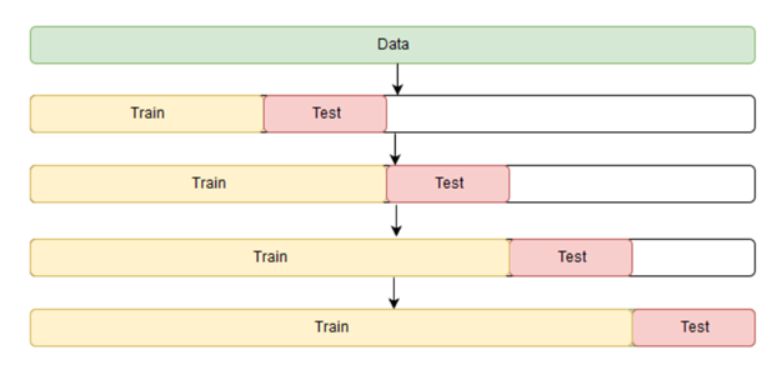

# Forecasts = Rolling Mean (4 Weeks)

In [6]:
df.loc[:, 'Sales_Rolling_Mean_Sales_QTY_W4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])['Sales_QTY'].transform(lambda x: x.shift(1).rolling(window=4,min_periods=0).mean()).fillna(0)

df.loc[:, 'Sales_Rolling_Mean_Turnover_W4'] = df.sort_values(by=['Year', 'Week']).groupby(
    ['SKU', 'Site_ID'])['Turnover'].transform(lambda x: x.shift(1).rolling(window=4,min_periods=0).mean()).fillna(0)

df

,Week,Year,Date,Site_ID,SKU,Sales_QTY,Turnover,Season_Year,Vendor_ID,Vendor_Name,...,Subclass_Desc,Class_Desc,Web_Article,Web_Article_From,Web_Article_To,CENSHARE_CAT_1,CENSHARE_CAT_2,CENSHARE_CAT_3,Sales_Rolling_Mean_Sales_QTY_W4,Sales_Rolling_Mean_Turnover_W4
0,4,2010,2010W4,101,1014557,4.0,103.599998,9999,0000126656,Schwarz Kitchen Selection SA,...,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser,0.000000,0.000000
1,5,2010,2010W5,101,1014557,1.0,25.900000,9999,0000126656,Schwarz Kitchen Selection SA,...,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser,4.000000,103.599998
2,6,2010,2010W6,101,1014557,2.0,51.799999,9999,0000126656,Schwarz Kitchen Selection SA,...,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser,2.500000,64.750000
3,7,2010,2010W7,101,1014557,0.0,0.000000,9999,0000126656,Schwarz Kitchen Selection SA,...,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser,2.333333,60.433334
4,8,2010,2010W8,101,1014557,0.0,0.000000,9999,0000126656,Schwarz Kitchen Selection SA,...,Zerkleinern,Kuechenhelfer,X,2015-01-28,9999-12-31,Kuche,Kuchenmesser,wiegemesser,1.750000,45.325001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10332825,47,2020,2020W47,101,1289328500,4.0,56.090000,9999,0000948934,HAY ApS,...,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe,0.000000,0.000000
10332826,47,2020,2020W47,101,1289328600,2.0,29.799999,9999,0000948934,HAY ApS,...,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe,0.000000,0.000000
10332827,47,2020,2020W47,101,1289328700,5.0,32.869999,9999,0000948934,HAY ApS,...,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe,0.000000,0.000000
10332828,47,2020,2020W47,101,1289328800,4.0,27.600000,9999,0000948934,HAY ApS,...,Wohnaccessoires,HAY,X,2021-02-25,9999-12-31,Ordnung & Aufbewahrung,Korbe & Boxen,korbe,0.000000,0.000000


In [7]:
rmse = []

splits = utils.get_splits(df, fh=1, n_splits=1)

for week, year in splits:
    week=int(week)
    year=int(year)
    

    y_pred = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][f'Sales_Rolling_Mean_{target_variable}_W4']
    y_test = df.loc[df.Year == (Week(year, week)+1)[0]].loc[df.Week == (Week(year, week)+1)[1]][target_variable]

    rmse.append(mean_squared_error(y_test, y_pred, squared=False))

print('RMSE:\n', rmse)
    
print('\nCrossvalidated RMSE: ', np.mean(rmse))

RMSE:
 [121.76987]

Crossvalidated RMSE:  121.76987


# Excursion: Compute Min Stock for next Week

In [8]:
relevant_columns = ['Week','Year','Site_ID','SKU','Sales_Rolling_Mean_Sales_QTY_W4','Min Stock','Article_Desc','Mainsector_ID','Mainsector_Desc','Warengruppe_ID', 'Warengruppe_Desc','Vendor_ID', 'Vendor_Name']
stock = df.loc[df.Date == df.Date.max()].copy()
stock.loc[:, 'Min Stock'] = np.ceil(df.Sales_Rolling_Mean_Sales_QTY_W4 * 2).clip(lower=1)
stock = stock.loc[:,relevant_columns]
stock = stock.rename(columns={'SKU': 'Article_ID', 'Sales_Rolling_Mean_Sales_QTY_W4': 'Forecast'})
stock = stock.sort_values(by=['Min Stock', 'Forecast'], ascending=False)
stock.to_csv('Wareverschiebung-VZ-zu-Filiale.csv', index=False, encoding='utf-8')
stock

,Week,Year,Site_ID,Article_ID,Forecast,Min Stock,Article_Desc,Mainsector_ID,Mainsector_Desc,Warengruppe_ID,Warengruppe_Desc,Vendor_ID,Vendor_Name
6742036,9,2020,107,1171625400,47.25,95.0,BECHER HOBSTAR 35CL,45,Home/Lifestyle,730,Tisch Hartwaren,0000147322,Kreavita Home Design AG
8868583,9,2020,101,1261293900,44.50,89.0,GIN TONIC MIXOLOGY 80CL,45,Home/Lifestyle,730,Tisch Hartwaren,0000147322,Kreavita Home Design AG
1820241,9,2020,116,25587914,35.00,70.0,DREAMFLOR SAND 30X30,45,Home/Lifestyle,630,Bad-Textilien,0000114207,Weseta Textil AG
10102626,9,2020,101,1280659300,27.25,55.0,STABKERZE SCHWARZ 22X240MM,45,Home/Lifestyle,988,Wohnboutique,0000942081,Herzog Kerzen AG
1528245,9,2020,101,23605368,24.50,49.0,BASIC OTA KAFFEE,45,Home/Lifestyle,730,Tisch Hartwaren,0000331934,Porzellanmanufaktur Kahla/Thüringen
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10238042,9,2020,101,1283749400,0.00,1.0,E/SIG. BRÄTER RUND D24CM SHELLPINK,45,Home/Lifestyle,721,Küche,0000101823,Le Creuset Swiss AG
10238147,9,2020,107,1283749400,0.00,1.0,E/SIG. BRÄTER RUND D24CM SHELLPINK,45,Home/Lifestyle,721,Küche,0000101823,Le Creuset Swiss AG
10238407,9,2020,106,1283755600,0.00,1.0,E/SIG. MARMITE-BRÄTER D24CM SHELLPINK,45,Home/Lifestyle,721,Küche,0000101823,Le Creuset Swiss AG
10238787,9,2020,590,1283756100,0.00,1.0,E/SALZMÜHLE H21CM SHELLPINK,45,Home/Lifestyle,721,Küche,0000101823,Le Creuset Swiss AG
